In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')  
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from html.parser import HTMLParser
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import cross_val_predict 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
import seaborn as sn


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jasonzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jasonzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
df_sent = pd.read_csv ('Sentiment.csv')
df_elect = pd.read_csv ('Canadian_elections_2019.csv')

# Part 1: Data Cleaning

The tweets, as given, are not in a form amenable to analysis -- there is too much ‘noise’.
Therefore, the first step is to “clean” the data. Design a procedure that prepares the Twitter
data for analysis by satisfying the requirements below.

    o All html tags and attributes (i.e., /<[^>]+>/) are removed.
    o Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
    o All URLs are removed.
    o All characters in the text are in lowercase.
    o All stop words are removed. Be clear in what you consider as a stop word.
    o If a tweet is empty after pre-processing, it should be preserved as such.
    
In addition, the definition of stopwords are based on the NLTK library, single-character words/numbers, as well as pre-defined tokens specific to the given data that either have high-frequency but carry little to no information about the election, or is not useful for sentiment analysis. 

With regards to the target variables for both datasets, it is observed that there are three unique values for the sentiment dataset: positive, negative, neutral. Considering that the 'neutral' tweets account for an insignificant portion of the total tweets (roughtly 2%), also that they do not provide as much insight into the sentiment analysis of tweets, these tweets are dropped from the data set. As a result, target variables are encoded into positive (1) and negative (0). The canadian election dataset does not contain 'neutral' sentiment values, therefore similar target encoding is performed. 

In [0]:
#define function for data cleaning 
def DataProcessor (tweet_list):
       
    stop_words = stopwords.words("english") + ['cdnpoli', 'elxn43', 'election', 'party', 'one', 'people', 'campaign', 'monday', 'get']
    
    for i in range(len(tweet_list)):

        #remove html tags/attributes
        clean = re.compile(r'/<[^>]+>/')
        tweet_list[i] = re.sub(clean, '', str(tweet_list[i]))
               
        #replace html character codes with ASCII equivalent
        parser = HTMLParser()
        tweet_list[i] = parser.unescape(tweet_list[i])
        
        #remove urls
        tweet_list[i] = re.sub(r"http\S+", '', str(tweet_list[i]))
        
        #remove punctuations
        tokenizer = RegexpTokenizer(r'\w+')
        tweet_list[i] = tokenizer.tokenize(tweet_list[i])
        tweet_list[i] = ' '.join(tweet_list[i]) 

        #remove single-character words and all numbers
        tokens = word_tokenize(tweet_list[i])
        filtered = [w for w in tokens if len(w) >1 ]
        filtered = [w for w in filtered if not w.isdigit()]
        tweet_list[i] = ' '.join(filtered)  
        
        #all lowercase characters
        tweet_list[i] = tweet_list[i].lower()
        
        #remove stopwords
        word_tokens = word_tokenize(tweet_list[i])
        filtered_tweet = [w for w in word_tokens if not w in stop_words]
        tweet_list[i] = ' '.join(filtered_tweet)    
        
    return tweet_list

In [0]:
sent_text_list = df_sent['text'].tolist()
elect_text_list = df_elect['text'].tolist()

#generating lists of cleaned tweets
sent_cleaned = DataProcessor(sent_text_list)
elect_cleaned = DataProcessor(elect_text_list)

/Users/jasonzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  


In [0]:
#adding cleaned texts to original df as new column
df_sent['Text_Cleaned'] = sent_cleaned
df_elect['Text_Cleaned'] = elect_cleaned

df_sent.head()
#df_elect.head()

,sentiment,text,Text_Cleaned
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...,rt diplomtc_immnty realdonaldtrump tried take ...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ...",chiefy74 damn jealous wan na watch fight love ...
2,Positive,I'm listening The Beatles now. They're great,listening beatles great
3,Positive,@ddlovato could i please get a shout out or an...,ddlovato could please shout anything huge fan ...
4,Positive,@salspizza just spotted ur message there Tony ...,salspizza spotted ur message tony replied


In [0]:
#unique values in the target variables for the sentiment dataset 3142 values that indicate neutral
df_sent.sentiment.value_counts()

Negative    71428
Positive    59241
Neutral      3142
Name: sentiment, dtype: int64

In [0]:
# dropping neutral tweets from sentiment dataset
df_sent.drop(df_sent[df_sent['sentiment'] == 'Neutral'].index, inplace=True)

# target encoding positive (1) and negative (0)
df_sent['target'] = [1 if x == 'Positive' else 0 for x in df_sent['sentiment']]
df_elect['target'] = [1 if x == 'Positive' else 0 for x in df_elect['sentiment']]

df_sent.head()

,sentiment,text,Text_Cleaned,target
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...,rt diplomtc_immnty realdonaldtrump tried take ...,1
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ...",chiefy74 damn jealous wan na watch fight love ...,0
2,Positive,I'm listening The Beatles now. They're great,listening beatles great,1
3,Positive,@ddlovato could i please get a shout out or an...,ddlovato could please shout anything huge fan ...,1
4,Positive,@salspizza just spotted ur message there Tony ...,salspizza spotted ur message tony replied,1


In [0]:
df_sent.sentiment.value_counts()

Negative    71428
Positive    59241
Name: sentiment, dtype: int64

# Part 2: Exploratory Analysis

A simple classifier for the determination of political parties of a given tweet is developed below based on the key words of each party. These keywords mainly include the leader as well as slogan of each of the liberal, conservative, and NDP. A tweet is classified based on the party with the maximum number of keywords.

From the histogram 'Political Party Distribution of Tweets' given below, it can be seen that the number of LP and CP affiliated tweets are similar, while being much greater than that of NDP. Also should be noted is that the category with the highest frequency is 'None'. This is expected since the algorithm will generate many false-negatives based on the simple classification criteria (keywords). 

Top 20 most-frequent tokens based on tweets from each of the csv files are plotting in the two histograms '20 Most Frequent Tokens in Sentiment.csv' and '20 Most Frequent Tokens in Canadian_elections_2019.csv'. In the later histogram, it can be seen that a majority of the most-frequent tokens are twitter emoji's (presented in UTF-8). Although emoji's are not words, they contain large sentimental information about the tweets, and therefore should be kept for further analysis.  


In [0]:
def party_classifier(tweet_list):
    
    #party keywords defined mainly based on party leaders and slogans
    liberal_key = ['red', 'justin trudeau', 'justintrudeau', 'liberal', 'liberals', 'chooseforward', 'chooseforward', 'incumbent', 'majority']
    conservative_key = ['blue','cpc', 'andrew scheer', 'andrewscheer', 'conservative', 'conservatives', 'time for you to get ahead', 'timeforyoutogetahead']
    ndp_key = ['orange', 'jagmeet singh', 'jagmeetsingh', 'ndp', 'in it for you', 'initforyou']
    party_name = []
    
    for i in range(len(tweet_list)):
        
        word_tokens = word_tokenize(tweet_list[i])        
    
        #keyword count 
        liberal_count = 0
        conservative_count = 0
        ndp_count = 0
        
        liberal_count = len([word for word in word_tokens if word in liberal_key])
        conservative_count = len([word for word in word_tokens if word in conservative_key])
        ndp_count = len([word for word in word_tokens if word in ndp_key])
        
        '''
        
        Classification is based on maximum count of party keywords in each tweet.
        
        In the case where two/three keyword counts are equal, classification includes all involved parties.
        
        If all keyword counts are zero, the tweet is classified as 'None'.
        
        '''
        
        if liberal_count > conservative_count and liberal_count > ndp_count:
            party_name.append('LP')
            
        elif conservative_count > liberal_count and conservative_count > ndp_count:
            party_name.append('CP')
            
        elif ndp_count > liberal_count and ndp_count > conservative_count:
            party_name.append('NDP')
            
        elif liberal_count == conservative_count != ndp_count != 0:
            party_name.append('LP/CP')
            
        elif liberal_count == ndp_count != conservative_count != 0:
            party_name.append('LP/NDP')
            
        elif conservative_count == ndp_count != liberal_count != 0:
            party_name.append('CP/NDP')
            
        elif liberal_count == conservative_count == ndp_count != 0:
            party_name.append('LP/CP/NDP')
        
        else:
            party_name.append('None')
            
            
    return party_name
    

In [0]:
#adding party classification to the original df
party = party_classifier(elect_text_list)
df_elect['Party'] = party

df_elect.head()

,sentiment,negative_reason,text,Text_Cleaned,target,Party
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton instead suggestion agree canadian ...,0,CP
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk real space_station etobicoke...,1,None
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford going cost billion next years ask ju...,0,None
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canada canadaelection2019 canadavotes ncan dec...,1,None
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpayers sick tired hard earned donate...,0,None


Text(0, 0.5, 'Frequency')

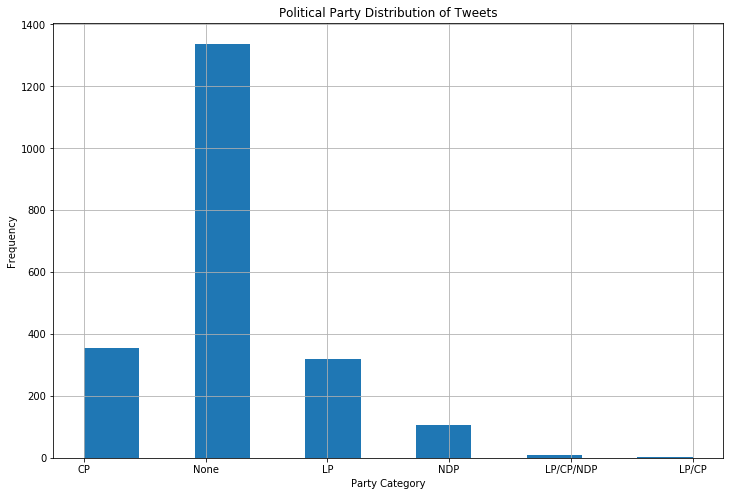

In [0]:
#plotting distribution of party affiliations of tweets
ax = df_elect['Party'].hist(figsize=(12,8), bins=11)
ax.set_title('Political Party Distribution of Tweets')
ax.set_xlabel('Party Category')
ax.set_ylabel('Frequency')

In [0]:
#combining all tweets and words into one list for cleaned tweets 
def tweet_words(tweet_list): 
    
    word_list = []
    
    for i in range(len(tweet_list)):

        word_tokens = word_tokenize(tweet_list[i])
        word_list.extend(word_tokens)
   
    return word_list
        
sent_words = tweet_words(df_sent['Text_Cleaned'].tolist()) 
elect_words = tweet_words(df_elect['Text_Cleaned'].tolist())

In [0]:
#counting top k most frequent words in each word list
def top_k_words(word_list, k):
    
    c = Counter(word_list)
    top_k = c.most_common(k)
    dict_word_count = { j[0]: j[1:] for j in top_k }
    words=list(dict_word_count.keys())
    counts=[]
    counts.append([top_k[i][1] for i in range(k)])
    counts = sum(counts, [])
    
    return words, counts

top_sent_words, top_sent_counts = top_k_words(sent_words, 20)
top_elect_words, top_elect_counts  = top_k_words(elect_words, 20)

Text(0, 0.5, 'Token')

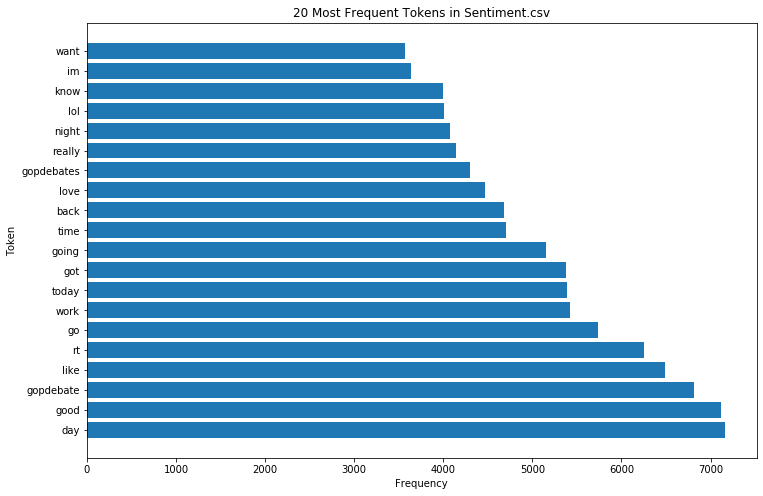

In [0]:
plt.figure(figsize=(12,8))
plt.barh(top_sent_words, top_sent_counts)
plt.title('20 Most Frequent Tokens in Sentiment.csv')
plt.xlabel('Frequency')
plt.ylabel('Token')

Text(0, 0.5, 'Token')

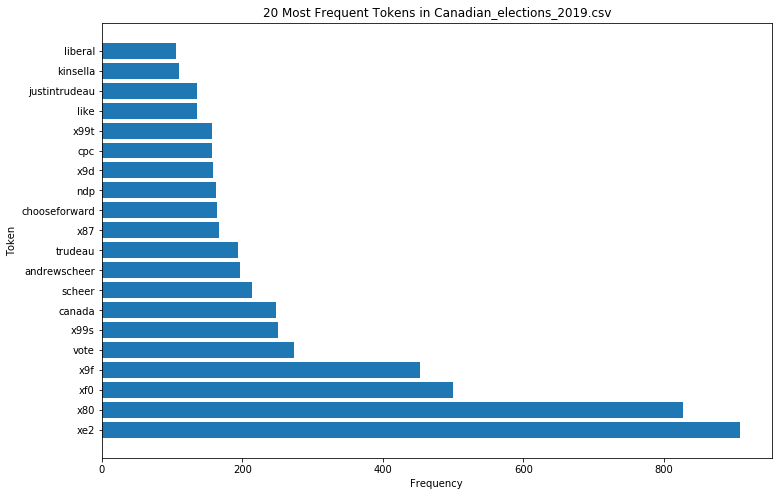

In [0]:
plt.figure(figsize=(12,8))
plt.barh(top_elect_words, top_elect_counts)
plt.title('20 Most Frequent Tokens in Canadian_elections_2019.csv')
plt.xlabel('Frequency')
plt.ylabel('Token')

# Part 3: Model Preparation

The generic tweets from Sentiment.csv are split into training(70%) and test(30%) sets, with the target variables being under the column 'target'. Then, each feature set is encoded into features based on word frequency, and TF-IDF. For both WF and TF-IDF, the features are the 100 most frequent words/tokens in the Sentiment.csv dataset. Note that since the selection of most frequent words for the training and test sets are performed on separate data sets, the features between training and test sets are not identical. This is to prevent overfitting the test set to the training set.

In [0]:
#feature set before encoding       
sent_X = df_sent['Text_Cleaned']
#target set
sent_y = df_sent['target']

#splitting tweet and sentiment values into 70% train and 30% test
sent_X_train, sent_X_test, sent_y_train, sent_y_test = train_test_split(sent_X, sent_y, test_size=0.3, random_state=0)

In [0]:
#encode k most-frequent words based on word frequency
def WF_sent_data(tweet_list, topkwords):
    
    df_rows = []
    
    for i in range(len(tweet_list)):

        word_tokens = word_tokenize(tweet_list[i])
        df_rows.append([word_tokens.count(word) if word in word_tokens else 0 for word in topkwords])
            
    #feature set        
    X = pd.DataFrame(df_rows, columns = topkwords)

    return X

In [0]:
#ecoding features based on word frequency for the top 100 most common words separately for train and test

#training set
WF_sent_X_train = WF_sent_data(sent_X_train.tolist(), list(top_k_words(tweet_words(sent_X_train.tolist()), 100))[0])

#test set
WF_sent_X_test = WF_sent_data(sent_X_test.tolist(), list(top_k_words(tweet_words(sent_X_test.tolist()), 100))[0])


In [0]:
#ecode k most-frequent words based on TF-IDF
def TFIDF_sent_data (tweet_list, k):

    tfidf = TfidfVectorizer(max_features=k)      
    x = tfidf.fit_transform(tweet_list)
    
    #feature set
    X = pd.DataFrame(x.toarray(), columns=tfidf.get_feature_names())
    
    return X

In [0]:
#ecoding features based on TFIDF for the top 100 most common words separately for train and test

#training feature set
TFIDF_sent_X_train = TFIDF_sent_data(sent_X_train.tolist(), 100)

#test feature set
TFIDF_sent_X_test = TFIDF_sent_data(sent_X_test.tolist(), 100)

In [0]:
WF_sent_X_train

,day,good,gopdebate,like,rt,go,work,today,got,going,...,life,awesome,fox,done,cant,weekend,feeling,please,show,thing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91464,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
91465,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
WF_sent_X_test

,good,day,like,gopdebate,rt,go,got,work,today,going,...,yes,life,awesome,ok,man,everyone,thing,watch,done,us
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39196,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
39199,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [0]:
#features in training set that are not in test set for word frequency
[w for w in WF_sent_X_train.columns if w not in WF_sent_X_test.columns]

['little', 'dont', 'trying', 'fox', 'feeling']

# Part 4: Model Implementation

For each of the classifiers that require hyperparameter tuning (decision tree, logistic regression, and random forest), the hyperparameters are tuned for both WF and TFIDF feature sets. Then, the sentiment data set is train on each model, with the accuracy of each model combination produced and compared. The model combination (model name, ideal hyperparameters, and feature type) with the highest prediction accuracy is chosen as the best model. Note that due to high amount of computational time required for model tuning, hyperparameters to be tuned are limited to 2 per model. The values/scale of hyperparameters explored are also limited. 

In [0]:
def DecisionTreeTuning(Xtrain, ytrain):
    '''
    
    Hyperparameter tuning for specified classifier.
    
    Only two parameters are chosen to be tuned due to high computation times.
    
    '''
    # Defining classifier
    tree = DecisionTreeClassifier()
    
    # Measurement criteria 
    criterion = ['gini', 'entropy']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]

    hyperparameters = dict(criterion=criterion, max_depth=max_depth)  #, max_features=max_features
    
    # Grid search with 5-fold cv
    clf = GridSearchCV(tree, hyperparameters, cv=5, verbose=0)
    best_model = clf.fit(Xtrain, ytrain)
    
    print('Best criterion for Decision Tree:', best_model.best_estimator_.get_params()['criterion'])
    print('Best max_depth Decision Tree:', best_model.best_estimator_.get_params()['max_depth'])
    
    tree_criterion = best_model.best_estimator_.get_params()['criterion']
    tree_max_depth = best_model.best_estimator_.get_params()['max_depth']
    
    return tree_criterion, tree_max_depth

In [0]:
# obtaining best hyperparameters for the decision tree model with WF
WF_tree_criterion, WF_tree_max_depth = DecisionTreeTuning(WF_sent_X_train, sent_y_train)

Best criterion for Decision Tree: entropy
Best max_depth Decision Tree: 50


In [0]:
# obtaining best hyperparameters for the decision tree model with TFIDF
TFIDF_tree_criterion, TFIDF_tree_max_depth = DecisionTreeTuning(TFIDF_sent_X_train, sent_y_train)

Best criterion for Decision Tree: entropy
Best max_depth Decision Tree: 50


In [0]:
def LogRegTuning(Xtrain, ytrain):

    #defining classifier
    logreg = LogisticRegression()
    
    #hyperparameters to be tuned
    penalty = ['l1', 'l2']
    C = np.logspace(0,2, num=10)
    
    hyperparameters = dict(penalty=penalty, C=C)  
    
    #grid search with 5-fold cv
    clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)
    best_model = clf.fit(Xtrain, ytrain)
    
    print('Best penalty for Logistic Regression:', best_model.best_estimator_.get_params()['penalty'])
    print('Best C for Logistic Regression:', best_model.best_estimator_.get_params()['C'])

    log_penalty = best_model.best_estimator_.get_params()['penalty']
    log_C = best_model.best_estimator_.get_params()['C']
    
    return log_penalty, log_C

In [0]:
# obtaining best hyperparameters for the logistic regression model with WF
WF_log_penalty, WF_log_C = LogRegTuning(WF_sent_X_train, sent_y_train)

Best penalty for Logistic Regression: l2
Best C for Logistic Regression: 1.0


In [0]:
# obtaining best hyperparameters for the logistic regression model with TFIDF
TFIDF_log_penalty, TFIDF_log_C = LogRegTuning(TFIDF_sent_X_train, sent_y_train)

Best penalty for Logistic Regression: l1
Best C for Logistic Regression: 1.0


In [0]:
def RandomForestTuning(Xtrain, ytrain):

    #defining classifier
    randforest = RandomForestClassifier(n_jobs=-1)
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 3)]
    # Measurement criteria 
    criterion = ['gini', 'entropy']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 50, num = 3)]

    hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth)  
    
    # cross validation is not used to save time
    clf = GridSearchCV(randforest, hyperparameters, verbose=0)
    best_model = clf.fit(Xtrain, ytrain)
    
    print('Best n_estimators for Random Forest:', best_model.best_estimator_.get_params()['n_estimators'])
    print('Best criterion for Random Forest:', best_model.best_estimator_.get_params()['criterion'])
    print('Best max_depth for Random Forest:', best_model.best_estimator_.get_params()['max_depth'])
    
    randforest_n_estimators = best_model.best_estimator_.get_params()['n_estimators']
    randforest_criterion = best_model.best_estimator_.get_params()['criterion']
    randforest_max_depth = best_model.best_estimator_.get_params()['max_depth']

    
    return randforest_n_estimators, randforest_criterion, randforest_max_depth

In [0]:
# obtaining best hyperparameters for the random forest model with WF
WF_randforest_n_estimators, WF_randforest_criterion, WF_randforest_max_depth = RandomForestTuning(WF_sent_X_train, sent_y_train)

Best n_estimators for Random Forest: 100
Best criterion for Random Forest: entropy
Best max_depth for Random Forest: 50


In [0]:
# obtaining best hyperparameters for the random forest model with TFIDF
TFIDF_randforest_n_estimators, TFIDF_randforest_criterion, TFIDF_randforest_max_depth = RandomForestTuning(TFIDF_sent_X_train, sent_y_train)

Best n_estimators for Random Forest: 500
Best criterion for Random Forest: entropy
Best max_depth for Random Forest: 50


In [0]:
# obtaining model accuracy for logistic regression for both WF and TFIDF
WF_logreg = LogisticRegression(penalty=WF_log_penalty, C=WF_log_C)
WF_logreg.fit(WF_sent_X_train, sent_y_train)
prediction1 = WF_logreg.predict(WF_sent_X_test)
print('The accuracy of the Logistic Regression model with WF is', metrics.accuracy_score(prediction1, sent_y_test))

TFIDF_logreg = LogisticRegression(penalty=TFIDF_log_penalty, C=TFIDF_log_C)
TFIDF_logreg.fit(WF_sent_X_train, sent_y_train)
prediction2 = TFIDF_logreg.predict(TFIDF_sent_X_test)
print('The accuracy of the Logistic Regression model with TFIDF is', metrics.accuracy_score(prediction2, sent_y_test))

The accuracy of the Logistic Regression model with WF is 0.5339914798091886
The accuracy of the Logistic Regression model with TFIDF is 0.5318741868829877


In [0]:
# obtaining model accuracy for decision tree for both WF and TFIDF
WF_tree = DecisionTreeClassifier(criterion=WF_tree_criterion, max_depth=WF_tree_max_depth)
WF_tree.fit(WF_sent_X_train, sent_y_train)
prediction3 = WF_tree.predict(WF_sent_X_test)
print('The accuracy of the Decision Tree model with WF is', metrics.accuracy_score(prediction3, sent_y_test))

TFIDF_tree = DecisionTreeClassifier(criterion=TFIDF_tree_criterion, max_depth=TFIDF_tree_max_depth)
TFIDF_tree.fit(TFIDF_sent_X_train, sent_y_train)
prediction4 = TFIDF_tree.predict(TFIDF_sent_X_test)
print('The accuracy of the Decision Tree model with TFIDF is', metrics.accuracy_score(prediction4, sent_y_test))

The accuracy of the Decision Tree model with WF is 0.5334302696359787
The accuracy of the Decision Tree model with TFIDF is 0.5139664804469274


In [0]:
# obtaining model accuracy for random forest for both WF and TFIDF
WF_randforest = RandomForestClassifier(n_estimators=WF_randforest_n_estimators, criterion=WF_randforest_criterion, max_depth=WF_randforest_max_depth)
WF_randforest.fit(WF_sent_X_train, sent_y_train)
prediction5 = WF_randforest.predict(WF_sent_X_test)
print('The accuracy of the Random Forest model with WF is',metrics.accuracy_score(prediction5, sent_y_test))

TFIDF_randforest = RandomForestClassifier(n_estimators=TFIDF_randforest_n_estimators, criterion=TFIDF_randforest_criterion, max_depth=TFIDF_randforest_max_depth)
TFIDF_randforest.fit(TFIDF_sent_X_train, sent_y_train)
prediction6 = TFIDF_randforest.predict(TFIDF_sent_X_test)
print('The accuracy of the Random Forest model with TFIDF is',metrics.accuracy_score(prediction6, sent_y_test))

The accuracy of the Random Forest model with WF is 0.5374352695084309
The accuracy of the Random Forest model with TFIDF is 0.5432004285604959


In [0]:
# obtaining model accuracy for naive bayes for both WF and TFIDF (without tuning)
WF_NB = GaussianNB()
WF_NB.fit(WF_sent_X_train, sent_y_train)
prediction7 = WF_NB.predict(WF_sent_X_test)
print('The accuracy of the Gaussian Naive Bayes model with WF is', metrics.accuracy_score(prediction7, sent_y_test))

TFIDF_NB = GaussianNB()
TFIDF_NB.fit(TFIDF_sent_X_train, sent_y_train)
prediction8 = TFIDF_NB.predict(TFIDF_sent_X_test)
print('The accuracy of the Gaussian Naive Bayes model with TFIDF is', metrics.accuracy_score(prediction8, sent_y_test))

The accuracy of the Gaussian Naive Bayes model with WF is 0.5302160659166858
The accuracy of the Gaussian Naive Bayes model with TFIDF is 0.5364403969286498


The models presented above demonstrate similar accuracy results, with Random Forest performing relatively better (~54% with TFIDF). Therefore, the best model is determined as follows:

- Model: Random Forest
- Feature type: TFIDF
- Hyperparameters: 
    - n_estimator = 500
    - criterion = 'entropy'
    - max_depth = 50

## Applying the Best Model for the Sentiment Data on the Canadian Election Data. 

The best model as shown above is used to train the 2019 Canadian Elections data, with 200 TFIDF features. We select more features for the elections dataset because its size is much smaller than the sentiment data.

In [0]:
#feature set before encoding       
elect_X = df_elect['Text_Cleaned']
#target set
elect_y = df_elect['target']

#splitting tweet and sentiment values into 70% train and 30% test
elect_X_train, elect_X_test, elect_y_train, elect_y_test = train_test_split(elect_X, elect_y, test_size=0.3, random_state=0)

In [0]:
#ecoding features based on TFIDF for the top 200 most common words separately for train and test

#training feature set
TFIDF_elect_X_train = TFIDF_sent_data(elect_X_train.tolist(), 200)

#test feature set
TFIDF_elect_X_test = TFIDF_sent_data(elect_X_test.tolist(), 200)

In [0]:
TFIDF_elect_X_train

,ableg,abpoli,alberta,also,andrew,andrewscheer,andy,another,answer,ask,...,xa6,xa8,xb8,xc2,xe2,xef,xf0,years,yes,yet
0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.481973,0.474902,0.0,0.481973,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.390984,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1489,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1490,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1491,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [0]:
#obtaining accuracy of the best model on the Canadian Election data
TFIDF_randforest = RandomForestClassifier(n_estimators=TFIDF_randforest_n_estimators, criterion=TFIDF_randforest_criterion, max_depth=TFIDF_randforest_max_depth)
TFIDF_randforest.fit(TFIDF_elect_X_train, elect_y_train)
prediction_elect = TFIDF_randforest.predict(TFIDF_elect_X_test)
print('The accuracy of the Random Forest model for the Candian Election Data is',metrics.accuracy_score(prediction_elect, elect_y_test))

The accuracy of the Random Forest model for the Candian Election Data is 0.596875


The accuracy of the best model for the Canadian Election data is around 60%, which is higher than the 54% of the Sentiment data. 

## Visualizing Sentiment Predictions and Comparing with the Election Result (excluding the training set). 

In [0]:
#adding prediction column to the test set
df_elect_test = df_elect.loc[elect_y_test.index]
df_elect_test['prediction'] = prediction_elect
df_elect_test

,sentiment,negative_reason,text,Text_Cleaned,target,Party,prediction
1968,Negative,Climate Problem,"b'Trudeau just said he\'s ""PROUD""(!) of his ac...",trudeau said proud activist candidate whose ma...,0,None,0
379,Negative,Scandal,"b""Lisa #Raitt always rubbed my ethics and mora...",lisa raitt always rubbed ethics morality wrong...,0,None,1
689,Negative,Women Reproductive right and Racism,b'@AndrewScheer You hired a firm to label fell...,andrewscheer hired firm label fellow canadians...,0,CP,0
935,Negative,Scandal,b'@mynamesnotgordy @ElizabethMay hired him!!! ...,mynamesnotgordy elizabethmay hired kinsellagat...,0,None,0
252,Positive,NaN,"b""Dear @AndrewScheer,\n\nSemper necessitas pro...",dear andrewscheer nsemper necessitas probandi ...,1,CP,0
...,...,...,...,...,...,...,...
1459,Negative,Others,"b'I mean that\'s ""fuck off and die"" in politic...",mean fuck die politics speak anyone casually d...,0,None,1
896,Positive,NaN,b'@LyleOberg @jkenney The case has been somewh...,lyleoberg jkenney case somewhat overstated hun...,1,None,1
1460,Positive,NaN,b'I miss the Doug Henning Transcendental Medit...,miss doug henning transcendental meditation ti...,1,None,1
1351,Positive,NaN,b'Free online access to The Globe starts today...,free online access globe starts today runs cov...,1,None,1


In [0]:
elect_y_test

1968    0
379     0
689     0
935     0
252     1
       ..
1459    0
896     1
1460    1
1351    1
383     0
Name: target, Length: 640, dtype: int64

Text(0.5, 1.0, 'Sentiment Predictions for Each Political Party')

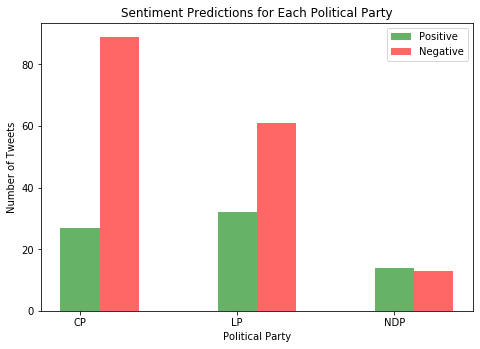

In [0]:
# Plotting prediction results for each party
CP_neg = df_elect_test[df_elect_test['Party']=='CP']['prediction'].value_counts()[0]
CP_pos = df_elect_test[df_elect_test['Party']=='CP']['prediction'].value_counts()[1]

LP_neg = df_elect_test[df_elect_test['Party']=='LP']['prediction'].value_counts()[0]
LP_pos = df_elect_test[df_elect_test['Party']=='LP']['prediction'].value_counts()[1]

NDP_neg = df_elect_test[df_elect_test['Party']=='NDP']['prediction'].value_counts()[0]
NDP_pos = df_elect_test[df_elect_test['Party']=='NDP']['prediction'].value_counts()[1]

positives = [CP_pos, LP_pos, NDP_pos]
negatives = [CP_neg, LP_neg, NDP_neg]

X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['CP', 'LP', 'NDP'], positives, color = 'g', width = 0.25, alpha=0.6)
ax.bar(X + 0.25, negatives, color = 'r', width = 0.25, alpha=0.6)
ax.legend(labels=['Positive', 'Negative'])
ax.set_xlabel('Political Party')
ax.set_ylabel('Number of Tweets')
ax.set_title('Sentiment Predictions for Each Political Party')

Text(0.5, 1.0, 'True Sentiment for Each Political Party')

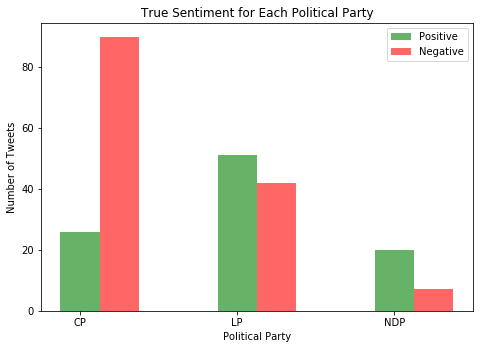

In [0]:
# Plotting true sentiment values for each party
CP_neg = df_elect_test[df_elect_test['Party']=='CP']['target'].value_counts()[0]
CP_pos = df_elect_test[df_elect_test['Party']=='CP']['target'].value_counts()[1]

LP_neg = df_elect_test[df_elect_test['Party']=='LP']['target'].value_counts()[0]
LP_pos = df_elect_test[df_elect_test['Party']=='LP']['target'].value_counts()[1]

NDP_neg = df_elect_test[df_elect_test['Party']=='NDP']['target'].value_counts()[0]
NDP_pos = df_elect_test[df_elect_test['Party']=='NDP']['target'].value_counts()[1]

positives = [CP_pos, LP_pos, NDP_pos]
negatives = [CP_neg, LP_neg, NDP_neg]

X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['CP', 'LP', 'NDP'], positives, color = 'g', width = 0.25, alpha=0.6)
ax.bar(X + 0.25, negatives, color = 'r', width = 0.25, alpha=0.6)
ax.legend(labels=['Positive', 'Negative'])
ax.set_xlabel('Political Party')
ax.set_ylabel('Number of Tweets')
ax.set_title('True Sentiment for Each Political Party')

From the two histograms presented above, the following observations can be made:

    - The number of tweets involving the Liberal and Conservative parties individually are much higher than that of the NDP.
    
    - Prediction results and true sentiment values for the Conservative party and NDP show similar trends, with positive sentiment being slightly higher than negative sentiment for the NDP, and negative being much higher than positive for the Conservative Party.
    
    - The trend for the liberal party in the prediction graph show opposite trend to the true sentiment graph. 
    
    - The model is more accurate for parties with greater differences in sentiment classes (positive/negative).
    
    - The model is more accurate at predicting negative sentiment. 
    
    - The model is able to predict the sentimental trends amongst the three parties, where the Liberal party has the highest number of positive sentiment, and the Conservative party has the highest negative sentiment. 
    
Overall, the prediction model is able to capture the general trend of the actual data, even more so if the difference amongst the sentiment classes is significant. In the case of the liberal party, which has slightly higher positive than negative sentiments(true sentiment), the model fails to predict data with much more negative sentiment than positives. However, the model correctly identifies that the Liberal party has the highest positive sentiment. Considering that the Liberal party has won the 2019 election, the model is partially representive of the election outcome. To summarize, NLP analytics can be useful for election campaigns in analyzing current political/social trends, in order to identify areas that can be improved. However, campaigns should not depend on the model to predict election outcomes.

## Analyzing 'negative' 2019 Canadian Election Tweets to Predict Reasoning for Negative Sentiment

As seen below, there are a total of 1006 tweets from the Canadian Election data with negative sentiment. There ten sentiment reason categories, which are encoded using Label Encoder. After encoding, the data is trained with multiclass classifiers. Specifically, OneVsRest (OVR) is used with the logistic regression and SVM models. The KNN model does not require OVR since it is inherently multiclass. 

In [0]:
# total number of negative tweets
len(df_elect[df_elect['target']==0])

1006

In [0]:
# categories for the column 'negative_reason'
df_elect['negative_reason'].value_counts()

Others                                 365
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

In [0]:
# tweets with positive sentiments are labeled with 'NaN' under 'negatie_reason'
# number of tweets with positive sentiment
df_elect['negative_reason'].isna().sum()

1126

In [0]:
# encoding reason classes using label encoder
# the class indicating positive sentiment ('NaN' or class 10 after encoding) will not be included in later analysis
le = LabelEncoder()
df_elect['reason_target'] = le.fit_transform(df_elect['negative_reason'].tolist())
df_elect

,sentiment,negative_reason,text,Text_Cleaned,target,Party,reason_target
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton instead suggestion agree canadian ...,0,CP,9
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk real space_station etobicoke...,1,None,10
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford going cost billion next years ask ju...,0,None,1
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canada canadaelection2019 canadavotes ncan dec...,1,None,10
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",canada taxpayers sick tired hard earned donate...,0,None,1
...,...,...,...,...,...,...,...
2128,Negative,Scandal,b'You know he was doing a good enough job smea...,know good enough job smearing right andrewsche...,0,CP,6
2129,Negative,Scandal,b'You missed the comment. Deflecting the issue...,missed comment deflecting issue answer best re...,0,None,6
2130,Positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...,daily reminder thejagmeetsingh endorses strate...,1,NDP,10
2131,Negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...,yup going reopen abortion debate xf0 x9f x98 x...,0,None,9


In [0]:
# original class distribution (note that class ten indicates positive sentiment, which we will not use)
df_elect['reason_target'].value_counts()

10    1126
4      365
6      270
8      198
1       51
9       45
0       41
7       16
5       12
2        5
3        4
Name: reason_target, dtype: int64

To balance as well as combine minority classes, we will join the following classes which are similar to each other:
                                
                                - Class 3 (Healthcare) = [2, 3]
                                - Class 9 (Social) = [5, 7, 9]
    
As a result, we have 7 remaining classes (excluding class 10, which are positive sentiment), with the following numbers of data for each class:

                                        10    1126
                                        4      365
                                        6      270
                                        8      198
                                        9       73
                                        1       51
                                        0       41
                                        3        9
                                        

In [0]:
# combining classes
df_elect['reason_target'].replace(2, 3, inplace=True)
df_elect['reason_target'].replace(5, 9, inplace=True)
df_elect['reason_target'].replace(7, 9, inplace=True)
df_elect['reason_target'].value_counts()

10    1126
4      365
6      270
8      198
9       73
1       51
0       41
3        9
Name: reason_target, dtype: int64

In [0]:
#feature set using cleaned tweets with negative sentiment
elect_X = df_elect[df_elect['target']==0]['Text_Cleaned']

#target set using 'negative reason' after encoding  
elect_y = df_elect[df_elect['target']==0]['reason_target']

#splitting tweet and sentiment values into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(elect_X, elect_y, test_size=0.3, random_state=0)

In [0]:
#training feature set encoding using TFIDF for top 50 most frequent words
TFIDF_X_train = TFIDF_sent_data(X_train.tolist(), 50)

#test feature set encoding using TFIDF
TFIDF_X_test = TFIDF_sent_data(X_test.tolist(), 50)

In [0]:
#knn multiclass 
knn = KNeighborsClassifier()
knn.fit(TFIDF_X_train, y_train)
knn_predict = knn.predict(TFIDF_X_test)
print('The accuracy of the KNN model for the Negative Sentiment Data is',metrics.accuracy_score(knn_predict, y_test))

The accuracy of the KNN model for the Negative Sentiment Data is 0.39072847682119205


In [0]:
# logistic regression with ovr
logreg = LogisticRegression(solver = 'lbfgs', multi_class='ovr')
logreg.fit(TFIDF_X_train, y_train)
logreg_predict = logreg.predict(TFIDF_X_test)
print('The accuracy of the Logistic Regression model for the Negative Sentiment Data is', metrics.accuracy_score(logreg_predict, y_test))

The accuracy of the Logistic Regression model for the Negative Sentiment Data is 0.46357615894039733


In [0]:
# SVM with OneVsRest
svm = SVC(decision_function_shape='ovr')
svm.fit(TFIDF_X_train, y_train)
svm_predict = svm.predict(TFIDF_X_test)
print('The accuracy of the SVM model for the Negative Sentiment Data is', metrics.accuracy_score(svm_predict, y_test))

The accuracy of the SVM model for the Negative Sentiment Data is 0.38079470198675497


### Bonus: Visualizing Confusion Matrix for Predictions of the Multiclass Logistic Regression Model

As seen in the confusion matrix below, the majority class 4 receives the highest % of correct predictions. Class 6 has the second highest % of correct predictions.  

[Text(0, 0.5, '0'),
 Text(0, 1.5, '1'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4'),
 Text(0, 4.5, '6'),
 Text(0, 5.5, '8'),
 Text(0, 6.5, '9')]

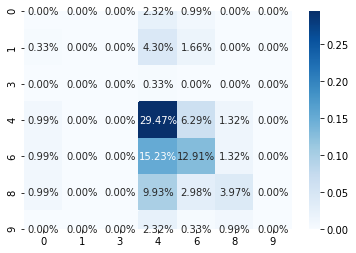

In [0]:
matrix = confusion_matrix(y_test, logreg_predict)
fig = sn.heatmap(matrix/np.sum(matrix), annot=True, fmt='.2%', cmap='Blues')
xlabels = [0, 1, 3, 4, 6, 8, 9]
ylabels = [0, 1, 3, 4, 6, 8, 9]
fig.set_xticklabels(xlabels)
fig.set_yticklabels(ylabels)

In [0]:
matrix

array([[ 0,  0,  0,  7,  3,  0,  0],
       [ 1,  0,  0, 13,  5,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0],
       [ 3,  0,  0, 89, 19,  4,  0],
       [ 3,  0,  0, 46, 39,  4,  0],
       [ 3,  0,  0, 30,  9, 12,  0],
       [ 0,  0,  0,  7,  1,  3,  0]])

With the multiclass logistic regression model, an accuracy of around 46% is obtained. This is lower than the previous models for sentiment predicition, which has only two classes to predict. 

# Part 5: Results

## Research question: “What can public opinion on Twitter tell us about the Canadian political landscape in 2019?”

Based on the first model, the following can be stated to answer the research question:

     - From the sentiment analysis of tweets regarding the 2019 canadian election, it is clear that both the Conservative and Liberal parties are much more popular than the NDP, based on both the predicted sentiment as well as the true sentiment. For the party (conservative) which has a large positive/negative sentiment difference, the first model succeeds in identifying this difference to a similar degree. However, the first model struggles for parties that have minor differences in positive/negative sentiment. In both cases (Liberal and NDP), the model assigns a much higher negative sentiment than positive, when the oppose is true. Overall, the model is much more successful at identifying negative sentiment than positive. 
     
     - The first model is able to predict the sentimental trends amongst the three parties. The Liberal party has the highest number of positive sentiment, and the Conservative party has the highest negative sentiment. 
     
Why the second model can fail to predict correctly:
     
     1.  Imbalanced data: the data is greatly imbalanced even after combining a few of the minority classes. The majority class (class 4) accounts for almost 40% of the total data. This mean that the model prediction can be biased towards the majority class. This is shown in logreg_predict as shown below. 
         
      2. Not enough data: there are 1007 total data points with negative sentiment for analysis. There is likely not enough data when we split it further into train/test, which results in only 704 data points for training, and 303 for testing. This may cause the model to fail at generalization and overfit to the training data. 
         
      3. Unclear labels: as state in the first point, class 4 ('Other') accounts for a significant portion of the data. 'Other' would indicate that the data is comprised of many minority classes that would rarely share commonalities. Together with other classes which are in small quantities, this means it can be difficult for the model to identify commonalities or differences amongst each class. 
     
Suggestion to improve the accuracy of each model:
     
    - Model 1: due to the large amount of computational time required, the tuning of the Random Forest Classifier is largely restricted. It would be helpful to explore more hyperparameters which can be tuned, as well as a larger scale of parameter values. For example, explore a higher value of max_depth.
    
    - Model 2: explore hyperparameter tuning for the multiclass logistic regression model. Also, to reduce the impace of the imbalanced dataset, attempt ways to evenly distribute the number of data in each class. For example, use oversampling techniques such as SMOTE to increase the size of minority classes. 
     

In [0]:
logreg_predict

array([4, 6, 4, 4, 4, 4, 6, 6, 4, 4, 8, 4, 4, 6, 4, 4, 4, 4, 4, 8, 4, 4,
       4, 6, 8, 4, 4, 6, 4, 4, 4, 6, 6, 4, 6, 4, 4, 6, 4, 6, 6, 6, 4, 6,
       4, 4, 8, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 4, 6, 4, 4, 6, 4, 6, 0, 4,
       6, 4, 6, 4, 4, 4, 4, 6, 4, 4, 8, 0, 4, 8, 4, 4, 4, 6, 4, 8, 4, 4,
       4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4,
       6, 8, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 8, 4, 4, 8, 8, 6, 4,
       4, 4, 8, 4, 4, 0, 6, 4, 4, 8, 0, 4, 6, 4, 6, 8, 4, 4, 4, 4, 8, 4,
       6, 4, 4, 6, 4, 6, 0, 4, 4, 6, 6, 8, 4, 6, 4, 4, 4, 6, 8, 6, 6, 4,
       6, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 6, 4, 4, 4, 6, 4, 6, 4,
       6, 4, 6, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 6, 6, 4, 6, 4, 8, 4, 0,
       4, 4, 4, 6, 4, 4, 6, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0,
       6, 4, 8, 4, 4, 6, 4, 4, 0, 4, 4, 4, 6, 4, 6, 4, 4, 4, 4, 6, 4, 4,
       6, 4, 4, 4, 0, 4, 6, 4, 8, 6, 4, 8, 4, 6, 0, 6, 4, 6, 4, 6, 4, 4,
       6, 4, 4, 6, 4, 6, 4, 6, 4, 4, 8, 4, 6, 4, 4,

In [0]:
X_train.shape

(704,)